# Analysis of Benchmarking Results for LSMTree

In [1]:
import os.path
import json
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

In [2]:
figdir = 'figures/lsm'
!mkdir -p $figdir

## Load and Preprocess Data

In [3]:
paths = glob('../dbf0java/benchmarks/disk_key_value/lsm/*.jsonl')
paths

['../dbf0java/benchmarks/disk_key_value/lsm/job5_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job4_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job2_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job7_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job1_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job6_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job3_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job0_results.jsonl']

In [4]:
duration_seconds = 60 * 60
op_cols = ['put', 'delete', 'get']
found_cols = ['get_found', 'delete_found']
constant_cols = ['value_length', 'base_index_rate']

results = []
for path in paths:
    with open(path, 'rt') as fp:
        for line in fp:
            spec, counts = json.loads(line)
            spec.update(counts)
            results.append(spec)

results = pd.DataFrame(results)

results = results.rename(columns={
    'getFound': 'get_found',
    'fileSize': 'data_size',
    'put_del_get': 'workload'
})

results = results[results['seconds'] == duration_seconds].drop('seconds', axis=1)
results['write_delta_threshold'] = results['pending_write_merge_threshold'] // int(1e5)
results['key_space_size'] = results['key_length'] // int(1e6)
results['known_key_rate'] = (results['known_key_rate'] * 100).astype(int)
results = results.drop(['key_length', 'deleteFound', 'type', 'pending_write_merge_threshold'], axis=1)

# early results incorrectly reported file size as just the directory entry size 
results.loc[results['data_size'] < 1e6, 'data_size'] = np.nan
results['data_size'] = (results['data_size'] / 1e9).round(1)


for col in constant_cols:
    assert results[col].nunique() == 1, f'{col} is not constant'
results = results.drop(constant_cols, axis=1)

print(len(results))
results.sample(5).T

154


,142,112,124,33,0
workload,GET_HEAVY,PUT_HEAVY,PUT_HEAVY,BALANCED,PUT_HEAVY
known_key_rate,10,90,10,10,50
thread_count,16,4,16,16,64
trial_index,0,9,7,1,5
put,13393776,164166429,192466475,27744474,453699894
delete,6697621,9117451,10697095,27742279,25202918
get,113856260,9114963,10691890,28587504,25211852
get_found,6116927,758369,5713784,908746,20557997
data_size,25.9,120.7,176.5,39.4,NaN
write_delta_threshold,1,1,10,1,10


In [5]:
col_description = {
    'put_del_get': 'Workload',
    'known_key_rate': 'Key Find Rate (%)',
    'thread_count': 'Threads',
    'write_delta_threshold': 'Write Delta Threshold (100,000s)',
    'key_space_size': 'Key Space Size (Millions)',
    'workload': 'Workload'
}

## Analysis of Final Data Size
(Sum of All Files for a Store)

In [6]:
results.sort_values('data_size', ascending=False).head(5).T

,89,115,122,64,45
workload,PUT_HEAVY,PUT_HEAVY,PUT_HEAVY,PUT_HEAVY,PUT_HEAVY
known_key_rate,90,50,90,90,90
thread_count,64,64,4,16,16
trial_index,1,8,9,7,4
put,225564193,177538737,284667295,119412486,318927728
delete,12533594,9861065,15810929,6633426,17718651
get,12532966,9864372,15816743,6631303,17713556
get_found,2429113,2132995,1420780,723973,2505429
data_size,356.1,264,226.5,196,179.3
write_delta_threshold,10,10,10,1,10


# Aggregate across different trials for same parameter combinations
Note, most scenarios should only have one trial

In [7]:
index_cols = [c for c in results.columns if c not in (op_cols + found_cols + [
    'base_index_rate', 'type', 'trial_index', 'data_size'])]
x = results.copy()
for col in op_cols:
    x[col] = (x[col] / duration_seconds / 1000).round(2).astype(float)
x['sum'] = x[op_cols].sum(axis=1).round(2)
y = x
agg_cols = op_cols + ['sum', 'data_size']
for col in op_cols + ['sum']:
    y[col] = y[col].astype(float)
y = y.groupby([c for c in index_cols if c in y.columns])[agg_cols].describe()
y = y.drop([(col, stat) for col in agg_cols for stat in ['std', 'mean']], axis=1)
norm_agg = y
norm_agg.sample(5).T

workload              PUT_HEAVY BALANCED          GET_HEAVY PUT_HEAVY
known_key_rate               50       50       90        90        50
thread_count                 16       64       4         4         1 
write_delta_threshold        10       1        10        10        1 
key_space_size             10       1000     100       100       10  
put       count          2.0000     1.00    3.000      1.00      1.00
          min          121.7800     7.23   34.160     16.76     38.15
          25%          124.0900     7.23   35.510     16.76     38.15
          50%          126.4000     7.23   36.860     16.76     38.15
          75%          128.7100     7.23   36.890     16.76     38.15
          max          131.0200     7.23   36.920     16.76     38.15
delete    count          2.0000     1.00    3.000      1.00      1.00
          min            6.7600     7.23   34.160      8.38      2.12
          25%            6.8900     7.23   35.505      8.38      2.12
          50%            7.0200     7.23   36.850      8.38      2.12
          75%            7.1500     7.23   36.885      8.38      2.12
          max            7.2800     7.23   36.920      8.38      2.12
get       count          2.0000     1.00    3.000      1.00      1.00
          min            6.7700     7.45   35.190    142.43      2.12
          25%            6.8975     7.45   36.580    142.43      2.12
          50%            7.0250     7.45   37.970    142.43      2.12
          75%            7.1525     7.45   38.005    142.43      2.12
          max            7.2800     7.45   38.040    142.43      2.12
sum       count          2.0000     1.00    3.000      1.00      1.00
          min          135.3100    21.91  103.510    167.57     42.39
          25%          137.8775    21.91  107.595    167.57     42.39
          50%          140.4450    21.91  111.680    167.57     42.39
          75%          143.0125    21.91  111.780    167.57     42.39
          max          145.5800    21.91  111.880    167.57     42.39
data_size count          2.0000     1.00    3.000      1.00      0.00
          min           16.6000    32.30   86.300     77.20       NaN
          25%           19.1000    32.30  110.900     77.20       NaN
          50%           21.6000    32.30  135.500     77.20       NaN
          75%           24.1000    32.30  140.050     77.20       NaN
          max           26.6000    32.30  144.600     77.20       NaN

In [8]:
agg_median = pd.concat([norm_agg[col]['50%'].rename(col) for col in op_cols + ['data_size','sum']], axis=1)
agg_median = agg_median.sort_values('sum', ascending=False)
agg_median.sample(5)

put  \
workload     known_key_rate thread_count write_delta_threshold key_space_size          
BALANCED     10             64           10                    1000            15.35   
GET_HEAVY    10             1            1                     1000             2.11   
             50             16           10                    1000             8.88   
DELETE_HEAVY 10             1            1                     1000             9.23   
             50             1            1                     1000            12.16   

                                                                               delete  \
workload     known_key_rate thread_count write_delta_threshold key_space_size           
BALANCED     10             64           10                    1000             15.35   
GET_HEAVY    10             1            1                     1000              1.06   
             50             16           10                    1000              4.44   
DELETE_HEAVY 10             1            1                     1000              9.23   
             50             1            1                     1000             12.16   

                                                                                 get  \
workload     known_key_rate thread_count write_delta_threshold key_space_size          
BALANCED     10             64           10                    1000            15.81   
GET_HEAVY    10             1            1                     1000            17.96   
             50             16           10                    1000            75.50   
DELETE_HEAVY 10             1            1                     1000             2.05   
             50             1            1                     1000             2.70   

                                                                               data_size  \
workload     known_key_rate thread_count write_delta_threshold key_space_size              
BALANCED     10             64           10                    1000                 79.8   
GET_HEAVY    10             1            1                     1000                  7.8   
             50             16           10                    1000                 48.3   
DELETE_HEAVY 10             1            1                     1000                 49.8   
             50             1            1                     1000                 63.9   

                                                                                 sum  
workload     known_key_rate thread_count write_delta_threshold key_space_size         
BALANCED     10             64           10                    1000            46.51  
GET_HEAVY    10             1            1                     1000            21.13  
             50             16           10                    1000            88.82  
DELETE_HEAVY 10             1            1                     1000            20.51  
             50             1            1                     1000            27.02

# Investigate the top and bottom performing scenarios

In [9]:
x = agg_median.copy()

x = x.rename_axis(index=col_description)
x = x.rename(columns={c:c.capitalize() for c in x.columns})
x = pd.concat({'Operations per a Second (Thousands)': x[['Put', 'Delete', 'Get', 'Sum']],
               'Final Data Size (GB)': x['Data_size'].rename('')}, axis=1)
x = x.dropna()
x = x.rename(columns={'':'x'})
x = x.reset_index(col_level=1)
x = x.rename(columns={'':'Benchmarking Scenario'})
x = x.rename(columns={'x':''})

top = pd.concat({'Top Performing Scenarios': x.head()}, axis=1)
display(top)

low = pd.concat({'Lowest Performing Scenarios': x.tail()}, axis=1)
display(low.tail())

print(' '.join(top.to_html(index=False).split()))
print()
print(' '.join(low.to_html(index=False).split()))


Top Performing Scenarios                            \
     Benchmarking Scenario                             
                  Workload Key Find Rate (%) Threads   
0                GET_HEAVY                90       4   
1             DELETE_HEAVY                90       4   
2                PUT_HEAVY                50       4   
3                GET_HEAVY                90       1   
4                 BALANCED                90      16   

                                                              \
                                                               
  Write Delta Threshold (100,000s) Key Space Size (Millions)   
0                               10                        10   
1                               10                        10   
2                               10                        10   
3                               10                        10   
4                               10                        10   

                                                                 \
  Operations per a Second (Thousands)                             
                                  Put   Delete      Get     Sum   
0                               32.85   16.420  279.170  328.44   
1                              143.41  143.410   31.870  318.69   
2                              183.30   10.185   10.185  203.67   
3                               18.70    9.350  158.970  187.02   
4                               57.29   57.300   59.040  173.63   

                        
  Final Data Size (GB)  
                        
0                 16.3  
1                 21.9  
2                 23.8  
3                  9.9  
4                 10.1

Lowest Performing Scenarios                            \
         Benchmarking Scenario                             
                      Workload Key Find Rate (%) Threads   
82                   GET_HEAVY                10       1   
83                   PUT_HEAVY                10       1   
84                DELETE_HEAVY                10       1   
85                    BALANCED                10      64   
86                    BALANCED                10       1   

                                                               \
                                                                
   Write Delta Threshold (100,000s) Key Space Size (Millions)   
82                                1                      1000   
83                                1                       100   
84                                1                      1000   
85                                1                      1000   
86                                1                       100   

                                                               \
   Operations per a Second (Thousands)                          
                                   Put Delete     Get     Sum   
82                                2.11   1.06  17.960  21.130   
83                               18.47   1.03   1.030  20.530   
84                                9.23   9.23   2.050  20.510   
85                                6.63   6.63   6.830  20.090   
86                                5.78   5.78   5.955  17.515   

                         
   Final Data Size (GB)  
                         
82                  7.8  
83                 81.4  
84                 49.8  
85                 32.5  
86                 22.8

<table border="1" class="dataframe"> <thead> <tr> <th colspan="10" halign="left">Top Performing Scenarios</th> </tr> <tr> <th colspan="5" halign="left">Benchmarking Scenario</th> <th colspan="4" halign="left">Operations per a Second (Thousands)</th> <th>Final Data Size (GB)</th> </tr> <tr> <th>Workload</th> <th>Key Find Rate (%)</th> <th>Threads</th> <th>Write Delta Threshold (100,000s)</th> <th>Key Space Size (Millions)</th> <th>Put</th> <th>Delete</th> <th>Get</th> <th>Sum</th> <th></th> </tr> </thead> <tbody> <tr> <td>GET_HEAVY</td> <td>90</td> <td>4</td> <td>10</td> <td>10</td> <td>32.85</td> <td>16.420</td> <td>279.170</td> <td>328.44</td> <td>16.3</td> </tr> <tr> <td>DELETE_HEAVY</td> <td>90</td> <td>4</td> <td>10</td> <td>10</td> <td>143.41</td> <td>143.410</td> <td>31.870</td> <td>318.69</td> <td>21.9</td> </tr> <tr> <td>PUT_HEAVY</td> <td>50</td> <td>4</td> <td>10</td> <td>10</td> <td>183.30</td> <td>10.185</td> <td>10.185</td> <td>203.67</td> <td>23.8</td> </tr> <tr> <td>GET_

# Impact of File Size and Relation to Key Space Size

,count,mean,std,min,25%,50%,75%,max
key_space_size,,,,,,,,
10,40.0,12.480000,5.811933,5.5,7.65,10.45,16.225,26.6
100,30.0,84.430000,60.922037,14.6,31.15,75.70,131.800,226.5
1000,34.0,95.908824,74.815925,7.8,47.55,73.10,130.750,356.1


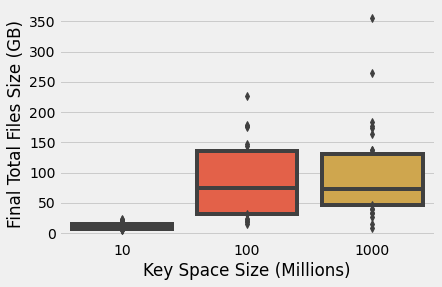

In [10]:
x = norm_agg['data_size']['50%'].rename('data_size').reset_index()
sns.boxplot(data=x, y='data_size', x='key_space_size', whis=0)
plt.ylabel('Final Total Files Size (GB)')
plt.xlabel('Key Space Size (Millions)')
plt.savefig(figdir + '/key_space_final_size.png', bbox_inches='tight')
results.groupby('key_space_size')['data_size'].describe()

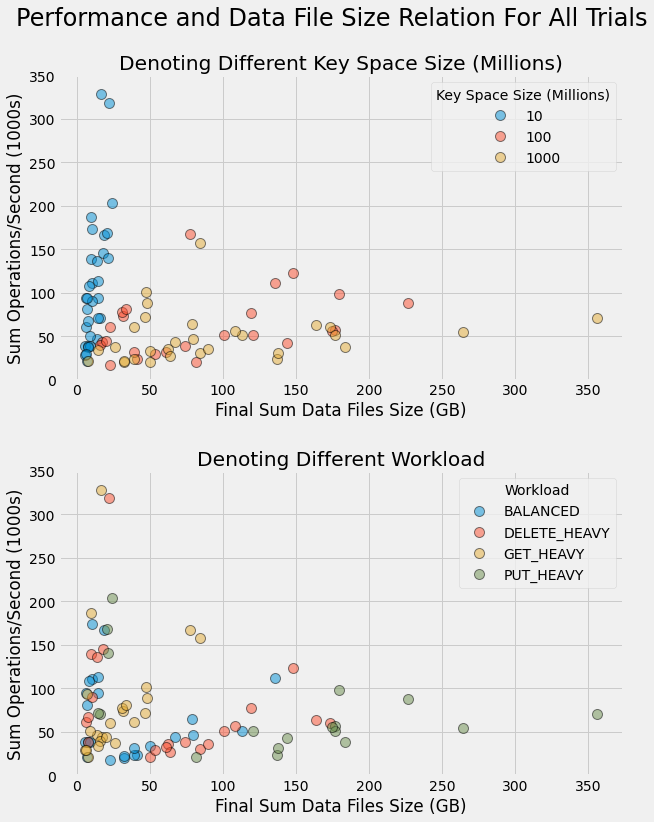

In [11]:
f = norm_agg['data_size']['50%'].rename('data_size')
s = norm_agg['sum']['50%'].rename('sum')
x = pd.concat([f, s], axis=1).loc[~np.isnan(f)]

fig = plt.figure(figsize=(9,12))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Performance and Data File Size Relation For All Trials', y=0.96, size=24)

for i, (gb_col, desc) in enumerate([
    ['key_space_size', 'Key Space Size (Millions)'],
    ['workload', 'Workload']
                                    ]):
    ax = fig.add_subplot(2, 1, i+1)
    for workload,y in x.groupby(gb_col):
        ax.plot(y['data_size'], y['sum'], 'o', label=workload, ms=10, alpha=0.5, mew=1, mec='k')
    plt.legend(loc='upper right', title=desc)
    plt.xlabel('Final Sum Data Files Size (GB)')
    plt.ylabel('Sum Operations/Second (1000s)')
    plt.title('Denoting Different ' + desc)
    plt.ylim(0, 350)

plt.savefig(figdir + '/file_size_sum_ops_relation.png', bbox_inches='tight')

# Impact of Individual Parameters on Performance

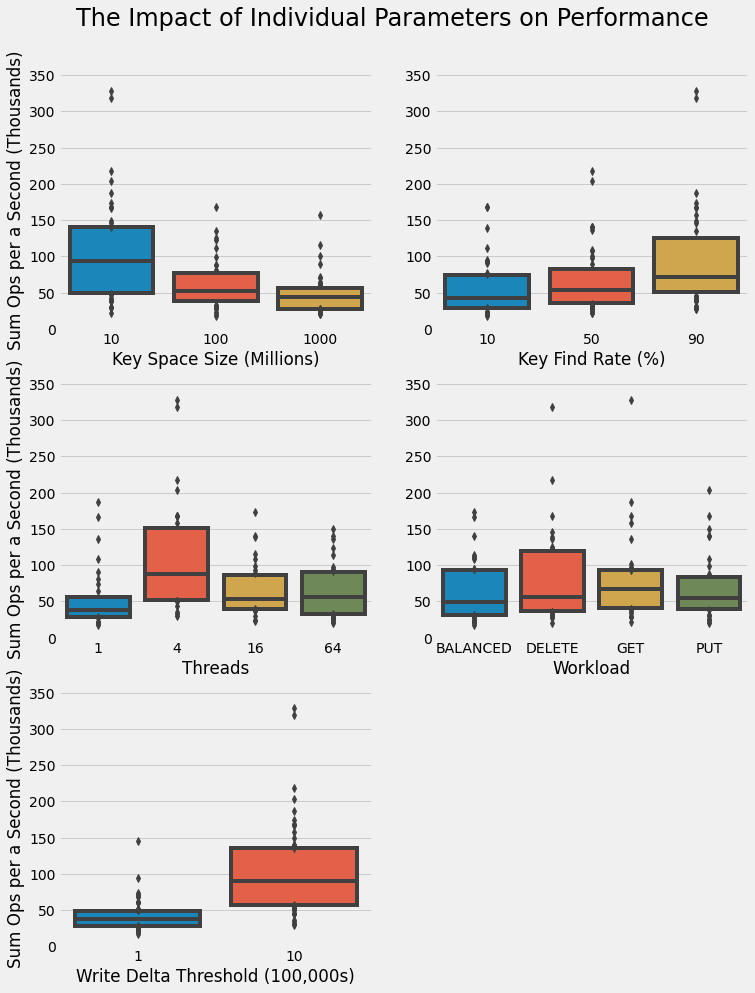

In [12]:
fig = plt.figure(figsize=(11,15))
x = norm_agg['sum'].copy()
cols = sorted(set(x.index.names) -
              {'key_length', 'type', 'parent_capacity', 'leaf_capacity', 'vacuum_threshold', 'base_index_rate',
              'file_size', 'value_length'})
x = x.reset_index()
x['workload'] = x['workload'].str.replace('_HEAVY', '')
for i,col in enumerate(cols):
    ax = fig.add_subplot(3, 2, i + 1)
    sns.boxplot(ax=ax, x=col, y="50%",
                  data=x,
                  whis=0)
    plt.ylim(0, 355)
    plt.ylabel('Sum Ops per a Second (Thousands)' if i%2==0 else '')
    plt.xlabel(col_description[col])
fig.subplots_adjust(hspace=0.2)
fig.suptitle('The Impact of Individual Parameters on Performance', y=0.94, size=24)
    
plt.savefig(figdir + '/benchmarking_indv_param.png', bbox_inches='tight')

## Materials for Project Page

In [13]:
import re

workloads = '''
PUT_HEAVY(0.9, 0.05)
GET_HEAVY(0.1, 0.05)
DELETE_HEAVY(0.45, 0.45)
BALANCED(0.33, 0.33)
'''

workloads = re.findall(r'([A-Z_]+)\(([\d.]+),\s+([\d.]+)', workloads)
workloads = pd.DataFrame(workloads, columns=['Workload', 'Put', 'Delete'])
workloads['Put'] = workloads['Put'].astype(float).mul(100).astype(int)
workloads['Delete'] = workloads['Delete'].astype(float).mul(100).astype(int)
workloads['Get'] = 100 - workloads['Put'] - workloads['Delete']
workloads = pd.concat({'Operation Frequency (%)':workloads.set_index('Workload')}, axis=1)
workloads = workloads.reset_index()
workloads = workloads.rename(columns={'Workload':'x'}).rename(columns={'':'Workload'}).rename(columns={'x':''})


display(workloads)

print(' '.join(workloads.to_html(index=False).split()))


Operation Frequency (%)           
       Workload                     Put Delete Get
0     PUT_HEAVY                      90      5   5
1     GET_HEAVY                      10      5  85
2  DELETE_HEAVY                      45     45  10
3      BALANCED                      33     33  34

<table border="1" class="dataframe"> <thead> <tr> <th></th> <th colspan="3" halign="left">Operation Frequency (%)</th> </tr> <tr> <th>Workload</th> <th>Put</th> <th>Delete</th> <th>Get</th> </tr> </thead> <tbody> <tr> <td>PUT_HEAVY</td> <td>90</td> <td>5</td> <td>5</td> </tr> <tr> <td>GET_HEAVY</td> <td>10</td> <td>5</td> <td>85</td> </tr> <tr> <td>DELETE_HEAVY</td> <td>45</td> <td>45</td> <td>10</td> </tr> <tr> <td>BALANCED</td> <td>33</td> <td>33</td> <td>34</td> </tr> </tbody> </table>
